In [71]:
# Імпорт бібліотек
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import fredapi as fd  # імпорт для роботи з FRED API


In [72]:
# Встановлення API ключа для FRED
fred = fd.Fred(api_key='d374b0e0f753010f7f02e70aa6fd8b9f')


In [ ]:
# Отримання даних
cpi_data = fred.get_series('CPIAUCNS', start_date='2010-01-01')  # Споживчий ціновий індекс
income_data = fred.get_series('MEPAINUSA646N', start_date='2010-01-01')  # Середній дохід


In [ ]:
# Створення DataFrame з отриманих даних
df = pd.DataFrame({
    'consumer_price_index': cpi_data,
    'average_income': income_data
}).dropna()


In [75]:
# Відображення перших рядків даних
print("Вибрані економічні дані:")
print(df.head())


Вибрані економічні дані:
            consumer_price_index  average_income
1974-01-01                  46.6          5335.0
1975-01-01                  52.1          5664.0
1976-01-01                  55.6          6002.0
1977-01-01                  58.5          6429.0
1978-01-01                  62.5          6813.0


In [76]:
# Підготовка даних
# Визначимо незалежні змінні та цільову змінну для моделювання.
X = df.drop("average_income", axis=1)  # незалежні змінні
y = df["average_income"]  # цільова змінна

# Розділення даних на навчальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:
# Модель лінійної регресії
mod = LinearRegression()
mod.fit(X_train, y_train)
predictions = mod.predict(X_test)
print("Лінійна регресія - перші три прогнози:", predictions[:3])  # Показати перші три прогнози


Лінійна регресія - перші три прогнози: [12545.47853271 29771.35768939 23250.17333951]


In [ ]:
# Модель K-найближчих сусідів
mod_knn = KNeighborsRegressor()
mod_knn.fit(X_train, y_train)
knn_predictions = mod_knn.predict(X_test)
print("KNN - перші три прогнози:", knn_predictions[:3])  

KNN - перші три прогнози: [11956. 28736. 23536.]


In [ ]:
# Модель дерева рішень
mod_tree = DecisionTreeRegressor()
mod_tree.fit(X_train, y_train)
tree_predictions = mod_tree.predict(X_test)
print("Дерево рішень - перші три прогнози:", tree_predictions[:3])  

Дерево рішень - перші три прогнози: [11550. 30240. 22670.]


In [ ]:
# Модель випадкового лісу
mod_rf = RandomForestRegressor()
mod_rf.fit(X_train, y_train)
rf_predictions = mod_rf.predict(X_test)
print("Випадковий ліс - перші три прогнози:", rf_predictions[:3])  

Випадковий ліс - перші три прогнози: [11799.5 29417.2 23102.6]


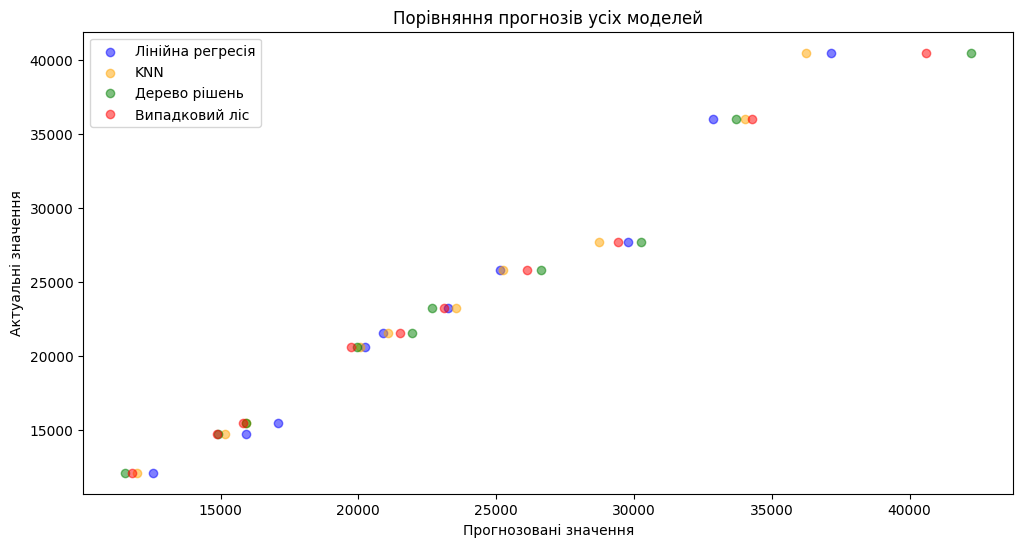

In [ ]:
# Візуалізація результатів
plt.figure(figsize=(12, 6))
plt.scatter(predictions, y_test, label='Лінійна регресія', color='blue', alpha=0.5)
plt.scatter(knn_predictions, y_test, label='KNN', color='orange', alpha=0.5)
plt.scatter(tree_predictions, y_test, label='Дерево рішень', color='green', alpha=0.5)
plt.scatter(rf_predictions, y_test, label='Випадковий ліс', color='red', alpha=0.5)
plt.xlabel('Прогнозовані значення')
plt.ylabel('Актуальні значення')
plt.title('Порівняння прогнозів усіх моделей')
plt.legend()
plt.show()

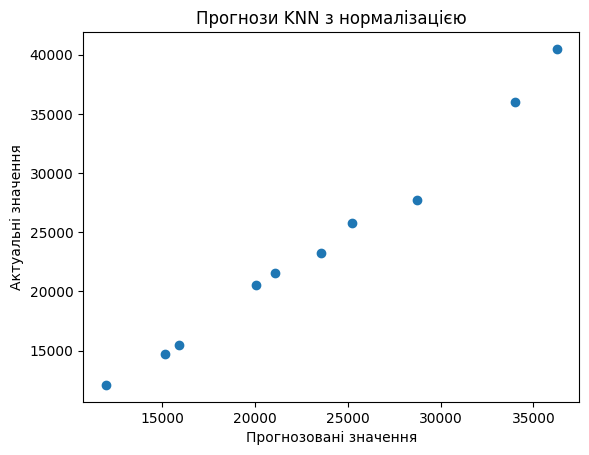

In [82]:
# Пайплайн для моделі KNN
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsRegressor())
])
pred = pipe.fit(X_train, y_train).predict(X_test)
plt.scatter(pred, y_test)
plt.xlabel('Прогнозовані значення')
plt.ylabel('Актуальні значення')
plt.title('Прогнози KNN з нормалізацією')
plt.show()

In [83]:
# Грид-серч для оптимізації параметрів
mod_grid = GridSearchCV(estimator=pipe,
                        param_grid={'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
                        cv=3)
mod_grid.fit(X_train, y_train)
print(pd.DataFrame(mod_grid.cv_results_))


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.003515      0.000173         0.001244    1.884846e-04   
1       0.002697      0.000550         0.001346    4.861501e-04   
2       0.001689      0.000456         0.001340    4.746860e-04   
3       0.002052      0.000064         0.001338    4.736745e-04   
4       0.001569      0.000420         0.002001    5.150430e-07   
5       0.002151      0.000204         0.001417    4.293818e-04   
6       0.002011      0.000004         0.001526    4.094884e-04   
7       0.002342      0.000242         0.001170    2.384970e-04   
8       0.002443      0.000610         0.000839    2.352711e-04   
9       0.002129      0.000161         0.001103    1.433100e-04   

   param_model__n_neighbors                      params  split0_test_score  \
0                         1   {'model__n_neighbors': 1}           0.983508   
1                         2   {'model__n_neighbors': 2}           0.974731   
2                         3 

In [84]:
# Найкращі параметри
print(f"Найкращі параметри KNN: {mod_grid.best_params_}")


Найкращі параметри KNN: {'model__n_neighbors': 1}


In [85]:
# Оцінка моделей
# Функція для обчислення MSE
def calculate_mse(true_values, predictions):
    return np.mean((true_values - predictions) ** 2)

# Обчислюємо MSE для кожної моделі
mse_linear = calculate_mse(y_test, predictions)
mse_knn = calculate_mse(y_test, knn_predictions)
mse_tree = calculate_mse(y_test, tree_predictions)
mse_rf = calculate_mse(y_test, rf_predictions)

print(f"Середня квадратична похибка (Лінійна регресія): {mse_linear:.2f}")
print(f"Середня квадратична похибка (KNN): {mse_knn:.2f}")
print(f"Середня квадратична похибка (Дерево рішень): {mse_tree:.2f}")
print(f"Середня квадратична похибка (Випадковий ліс): {mse_rf:.2f}")


Середня квадратична похибка (Лінійна регресія): 3071209.17
Середня квадратична похибка (KNN): 2414547.60
Середня квадратична похибка (Дерево рішень): 1688630.00
Середня квадратична похибка (Випадковий ліс): 707579.40
